## Assignment 03

### Part 1: Image Generation and Embedding Extraction

In [75]:
import torch
import clip
from utils import UNet_utils, ddpm_utils

In [76]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [77]:
IMG_SIZE = 32
IMG_CH = 3
BATCH_SIZE = 128
INPUT_SIZE = (IMG_CH, IMG_SIZE, IMG_SIZE)

T = 400
B_start = 0.0001
B_end = 0.02
B = torch.linspace(B_start, B_end, T).to(device)
ddpm = ddpm_utils.DDPM(B, device)

clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512

In [78]:
# Initialize the UNet model identical to the one in notebook 05.
model = UNet_utils.UNet(
    T, IMG_CH, IMG_SIZE, down_chs=(256, 256, 512), t_embed_dim=8, c_embed_dim=CLIP_FEATURES
)

# Load the pre-trained model weights
model.load_state_dict(torch.load("ddpm_clip_flowers.pth", map_location=device))

model = model.to(device)
model.eval()

UNet(
  (down0): ResidualConvBlock(
    (conv1): GELUConvBlock(
      (model): Sequential(
        (0): Conv2d(3, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 256, eps=1e-05, affine=True)
        (2): GELU(approximate='none')
      )
    )
    (conv2): GELUConvBlock(
      (model): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): GroupNorm(8, 256, eps=1e-05, affine=True)
        (2): GELU(approximate='none')
      )
    )
  )
  (down1): DownBlock(
    (model): Sequential(
      (0): GELUConvBlock(
        (model): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(32, 256, eps=1e-05, affine=True)
          (2): GELU(approximate='none')
        )
      )
      (1): GELUConvBlock(
        (model): Sequential(
          (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): GroupNorm(32, 256, eps

In [79]:
# List of Text Prompts to genereate Images From
text_prompts = [
    "A photo of a dark red rose",
    "A photo of a white daisy with a yellow center",
    "A photo of a yellow sunflower with a bronisch center",
]

In [80]:
# --- Embedding Extraction using Hooks ---
embeddings_storage = {}

def get_embedding_hook(name):
    def hook(model, input, output):
        embeddings_storage[name] = output.detach()
    return hook

# Register hooks to capture embeddings from the "down2" layer of the U-Net model
model.down2.register_forward_hook(get_embedding_hook("down2"))

In [81]:
def sample_flowers(text_list):
    text_tokens = clip.tokenize(text_list).to(device)
    c = clip_model.encode_text(text_tokens).float()
    x_gen, x_gen_store = ddpm_utils.sample_w(model, ddpm, INPUT_SIZE, T, c, device)
    return x_gen, x_gen_store

In [82]:
generated_images, _ = sample_flowers(text_prompts)

extracted_embeddings = embeddings_storage['down2']

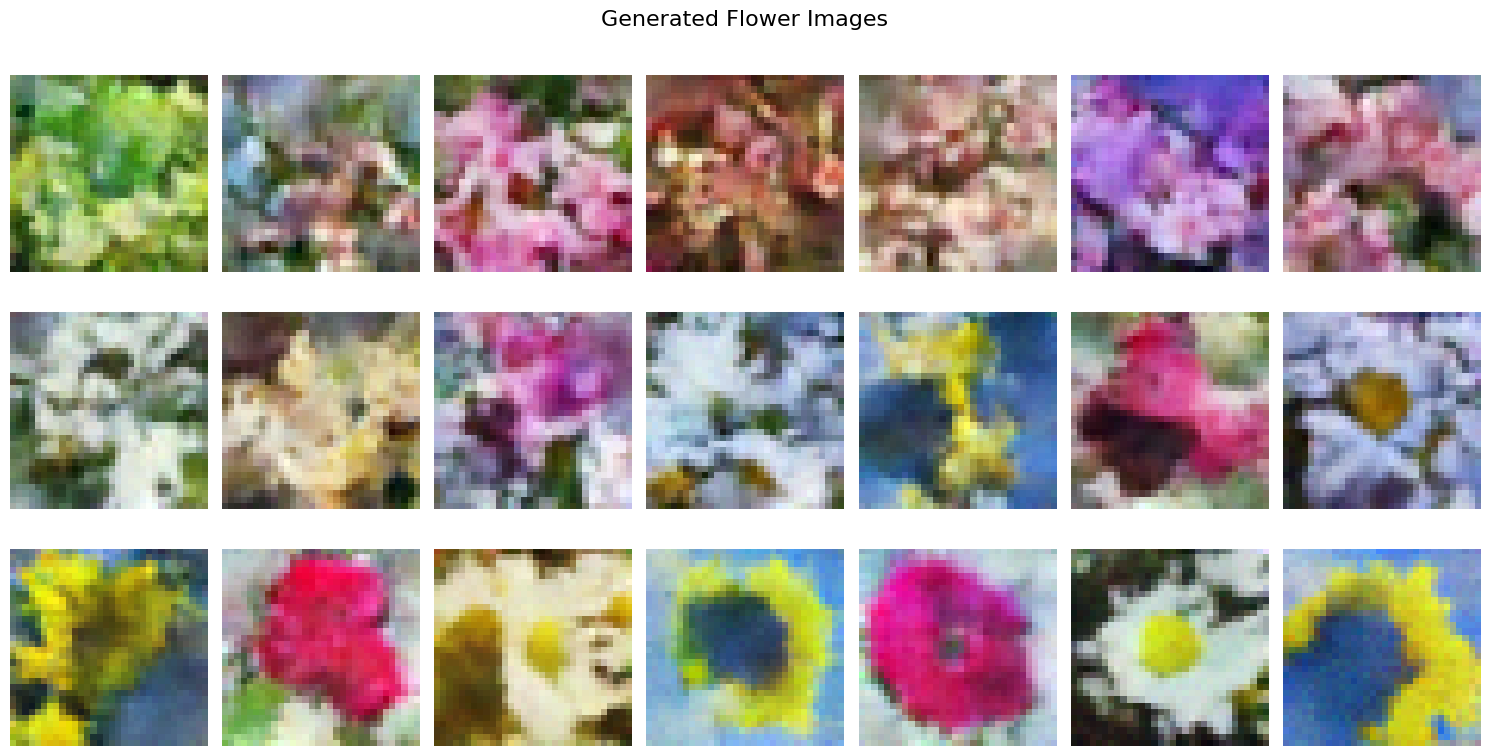

Displayed 21 images (3 prompts × 7 samples each)


In [83]:
# Display all generated images in a grid
import matplotlib.pyplot as plt

num_images = generated_images.shape[0]
samples_per_prompt = num_images // len(text_prompts)

# Create a grid layout: rows = prompts, cols = samples per prompt
fig, axes = plt.subplots(len(text_prompts), samples_per_prompt, figsize=(15, 8))
fig.suptitle('Generated Flower Images', fontsize=16, y=0.98)

for i in range(num_images):
    prompt_idx = i // samples_per_prompt
    sample_idx = i % samples_per_prompt
    
    # Select the appropriate subplot
    if len(text_prompts) == 1:
        ax = axes[sample_idx]
    elif samples_per_prompt == 1:
        ax = axes[prompt_idx]
    else:
        ax = axes[prompt_idx, sample_idx]
    
    # Prepare image for display
    img = generated_images[i].cpu().permute(1, 2, 0).numpy()
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
    
    ax.imshow(img)
    ax.axis('off')
    
    # Add title only for first image in each row
    if sample_idx == 0:
        ax.set_ylabel(text_prompts[prompt_idx], fontsize=10, rotation=0, 
                      ha='right', va='center', labelpad=20)

plt.tight_layout()
plt.show()

print(f"Displayed {num_images} images ({len(text_prompts)} prompts × {samples_per_prompt} samples each)")

In [84]:
print("Generated Images Shape:", generated_images.shape)
print("Text Prompts Length:", len(text_prompts))
print("Extracted Embeddings Shape:", extracted_embeddings.shape)
print("Sample Emebedding Vector (first prompt, first 10 values):")
print(extracted_embeddings[0, 0, :10][0])

Generated Images Shape: torch.Size([21, 3, 32, 32])
Text Prompts Length: 3
Extracted Embeddings Shape: torch.Size([42, 512, 8, 8])
Sample Emebedding Vector (first prompt, first 10 values):
tensor([-0.0380,  0.1687, -0.0543, -0.1119, -0.1679, -0.1262, -0.1025, -0.0829],
       device='cuda:0')


### Part 2: Evaluation with CLIP Score and Frechet Inception Distance (FID)

#### Metric Calculation

In [85]:
import open_clip
from PIL import Image
import numpy as np
from scipy.linalg import sqrtm

##### CLIP Score Calculation

In [86]:
def calculate_clip_score(image_path, text_prompt):
    # Load model
    model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-32', pretrained='laion2b_s34b_b79k')

    # Preprocess inputs
    image = preprocess(Image.open(image_path)).unsqueeze(0)

    tokenizer = open_clip.get_tokenizer('ViT-B-32')
    text = tokenizer([text_prompt])

    # Compute features and similarity
    with torch.no_grad():
        image_features = model.encode_image(image)
        text_features = model.encode_text(text)
        
        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Calculate dot product
        score = (image_features @ text_features.T).item()

    return score

##### Frechet Inception Distance (FID) Calculation

In [87]:
def calculate_fid(real_embeddings, gen_embeddings):
    # Calculate mean and covariance
    mu1, sigma1 = real_embeddings.mean(axis=0), np.cov(real_embeddings,rowvar=False)
    mu2, sigma2 = gen_embeddings.mean(axis=0), np.cov(gen_embeddings, rowvar=False)
    
    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2)

    # Calculate sqrt of product of covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Handle numerical errors
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Final FID calculation
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)

    return fid

In [88]:
# Calculate CLIP scores for each generated image
import torchvision.transforms as transforms
from pathlib import Path
to_pil = transforms.ToPILImage()

# Helper function to normalize images properly
def normalize_image(img_tensor):
    """Normalize image tensor to [0, 1] range for proper display"""
    img = img_tensor.cpu()
    img_np = img.permute(1, 2, 0).numpy()
    # Normalize to [0, 1]
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
    # Convert back to tensor in CHW format
    img_normalized = torch.from_numpy(img_np).permute(2, 0, 1)
    return img_normalized

# Determine how many samples per prompt
num_prompts = len(text_prompts)
num_images = len(generated_images)
samples_per_prompt = num_images // num_prompts

# Create directory for generated images
import os
os.makedirs("generated_images", exist_ok=True)

clip_scores = []
print("Calculating CLIP scores...")
for i, img in enumerate(generated_images):
    # Map image index to prompt index
    prompt_idx = i // samples_per_prompt
    if prompt_idx >= num_prompts:
        prompt_idx = num_prompts - 1
    
    # Normalize and save image to disk
    img_path = f"generated_images/generated_image_{i}.png"
    img_normalized = normalize_image(img)
    img_pil = to_pil(img_normalized)
    img_pil.save(img_path)
    
    # Calculate CLIP score
    score = calculate_clip_score(img_path, text_prompts[prompt_idx])
    clip_scores.append(score)
    
average_clip_score = sum(clip_scores) / len(clip_scores)
print(f"Average CLIP Score: {average_clip_score:.4f}\n")

# Calculate FID score
print("Loading real images from TF-Flowers dataset...")
from PIL import Image
import glob

# Load real images from the dataset
real_image_paths = []
flower_dir = Path("data/cropped_flowers")
for subdir in ["daisy", "roses", "sunflowers"]:
    real_image_paths.extend(glob.glob(str(flower_dir / subdir / "*.jpg")))

print(f"Found {len(real_image_paths)} real images")

# Preprocess transform to ensure consistent sizing
preprocess_load = transforms.Compose([
    transforms.Resize((32, 32)),  # Match generated image size
    transforms.ToTensor()
])

# Load and preprocess real images (limiting to match generated size for faster computation)
real_images_list = []
for img_path in real_image_paths[:100]:  # Use first 100 images
    img = Image.open(img_path).convert('RGB')
    img_tensor = preprocess_load(img)
    real_images_list.append(img_tensor)

# Create Inception feature extractor from cell 20 pattern
from torchvision.models import inception_v3, Inception_V3_Weights
import torch.nn as nn

class InceptionFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        inception = inception_v3(weights=Inception_V3_Weights.DEFAULT)
        self.conv_layers = nn.Sequential(
            inception.Conv2d_1a_3x3, inception.Conv2d_2a_3x3, inception.Conv2d_2b_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception.Conv2d_3b_1x1, inception.Conv2d_4a_3x3,
            nn.MaxPool2d(kernel_size=3, stride=2),
            inception.Mixed_5b, inception.Mixed_5c, inception.Mixed_5d,
            inception.Mixed_6a, inception.Mixed_6b, inception.Mixed_6c,
            inception.Mixed_6d, inception.Mixed_6e,
            inception.Mixed_7a, inception.Mixed_7b, inception.Mixed_7c,
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return x

# Extract features from real and generated images
feature_extractor = InceptionFeatureExtractor().to(device)
feature_extractor.eval()

preprocess_inception = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

print("Extracting features from real images...")
with torch.no_grad():
    real_imgs_preprocessed = torch.stack([preprocess_inception(img) for img in real_images_list]).to(device)
    real_embeddings = feature_extractor(real_imgs_preprocessed).cpu().numpy()

print("Extracting features from generated images...")
with torch.no_grad():
    gen_imgs_preprocessed = torch.stack([preprocess_inception(img) for img in generated_images]).to(device)
    gen_embeddings = feature_extractor(gen_imgs_preprocessed).cpu().numpy()


# Calculate FIDprint(f"FID Score: {fid_score:.4f}")

print("Calculating FID score...")
fid_score = calculate_fid(real_embeddings, gen_embeddings)

Calculating CLIP scores...
Average CLIP Score: 0.1758

Loading real images from TF-Flowers dataset...
Found 1166 real images
Extracting features from real images...
Extracting features from generated images...
Calculating FID score...


### Part 3: Embedding Analysis with FiftyOne Brain

In [89]:
import fiftyone as fo
import fiftyone.brain as fob

In [90]:
# Create new FiftyOne dataset
dataset_name = "generated_flowers_with_embeddings"
if fo.dataset_exists(dataset_name):
    fo.delete_dataset(dataset_name)
dataset = fo.Dataset(name=dataset_name)

In [91]:
# For each image, create a fiftyone.Sample and add the following metadata:
# - The file path to the saved image.
# - The text prompt (as a `fo.Classification` label).
# - The CLIP score (as a custom field).
# - The extracted U-Net embedding (as a custom field).

# Map images to their corresponding prompts
samples_per_prompt = len(generated_images) // len(text_prompts)

for i, img in enumerate(generated_images):
    # Map image index to prompt index
    prompt_idx = i // samples_per_prompt
    if prompt_idx >= len(text_prompts):
        prompt_idx = len(text_prompts) - 1
    
    # Normalize and save image to disk (using same normalization as matplotlib)
    img_path = f"generated_images/generated_image_{i}.png"
    img_normalized = normalize_image(img)
    img_pil = to_pil(img_normalized)
    img_pil.save(img_path)
    
    # Flatten the U-Net embedding (from [512, 8, 8] to [32768])
    embedding_flat = extracted_embeddings[i].cpu().numpy().flatten()
    
    # Create sample
    sample = fo.Sample(
        filepath=img_path,
        prompt=fo.Classification(label=text_prompts[prompt_idx]),
        clip_score=clip_scores[i],
        unet_embedding=embedding_flat
    )
    dataset.add_sample(sample)

print(f"Added {len(dataset)} samples to the dataset")

# Now that the dataset is populated, use FiftyOne Brain to compute visualization
# Compute visualization using the U-Net embeddings
results = fob.compute_visualization(dataset, embeddings="unet_embedding", brain_key="unet_viz")
print(f"Visualization computed successfully with {len(results.points)} points")

Added 21 samples to the dataset
Generating visualization...


INFO:fiftyone.brain.visualization:Generating visualization...


UMAP( verbose=True)
Tue Jan 20 23:46:32 2026 Construct fuzzy simplicial set
Tue Jan 20 23:46:32 2026 Finding Nearest Neighbors
Tue Jan 20 23:46:32 2026 Finished Nearest Neighbor Search
Tue Jan 20 23:46:32 2026 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Tue Jan 20 23:46:32 2026 Finished embedding
Visualization computed successfully with 21 points


In [92]:
# Compute uniqueness of the dataset based on U-Net embeddings
fob.compute_uniqueness(dataset)

# Compute representativeness of the dataset based on U-Net embeddings
fob.compute_representativeness(dataset, embeddings="unet_embedding")

Computing embeddings...


INFO:fiftyone.brain.internal.core.utils:Computing embeddings...
/sc/home/josef.pribbernow/.cache/pypoetry/virtualenvs/acv-v9FP04ar-py3.12/lib/python3.12/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 24 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


 100% |███████████████████| 21/21 [2.0s elapsed, 0s remaining, 10.4 samples/s]      


INFO:eta.core.utils: 100% |███████████████████| 21/21 [2.0s elapsed, 0s remaining, 10.4 samples/s]      


Computing uniqueness...


INFO:fiftyone.brain.internal.core.uniqueness:Computing uniqueness...


Uniqueness computation complete


INFO:fiftyone.brain.internal.core.uniqueness:Uniqueness computation complete


Computing representativeness...


INFO:fiftyone.brain.internal.core.representativeness:Computing representativeness...


Computing clusters for 21 embeddings; this may take awhile...


INFO:fiftyone.brain.internal.core.representativeness:Computing clusters for 21 embeddings; this may take awhile...


Representativeness computation complete


INFO:fiftyone.brain.internal.core.representativeness:Representativeness computation complete


In [93]:
session = fo.launch_app(dataset)

### Part 4: Logging with Weights & Biases

In [94]:
import wandb
wandb.login()

True

In [95]:
# Initialize a new wandb run
run = wandb.init(project="Assignment_03")

# Log hyperparameters
wandb.config.update({
    "num_steps": T,
    "batch_size": BATCH_SIZE,
    "img_size": IMG_SIZE,
    "num_prompts": len(text_prompts),
    "samples_per_prompt": samples_per_prompt,
    "beta_start": B_start,
    "beta_end": B_end,
})

# Log evaluation metrics (CLIP Score and FID)
wandb.log({
    "average_clip_score": average_clip_score,
    "fid_score": fid_score,
})

# Create wandb Table to log results with properly normalized images
table = wandb.Table(columns=["image", "prompt", "clip_score", "uniqueness", "representativeness"])

for idx, sample in enumerate(dataset):
    # Load and normalize image for wandb (to match matplotlib display)
    img_tensor = generated_images[idx]
    img_np = img_tensor.cpu().permute(1, 2, 0).numpy()
    img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())  # Normalize to [0, 1]
    img_np = (img_np * 255).astype('uint8')  # Convert to 0-255 range for wandb
    
    img = wandb.Image(img_np)
    prompt = sample.prompt.label
    clip_score = sample.clip_score
    uniqueness = sample.uniqueness if hasattr(sample, 'uniqueness') else None
    representativeness = sample.representativeness if hasattr(sample, 'representativeness') else None
    
    table.add_data(img, prompt, clip_score, uniqueness, representativeness)

wandb.log({"generated_flowers_table": table})

print("Results logged to W&B successfully!")

# Finish the wandb run
run.finish()

Results logged to W&B successfully!


average_clip_score,▁
fid_score,▁
average_clip_score,0.17579
fid_score,342.79933
